In [1]:
import os
import torch
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer
from torchdiffeq import odeint
from omegaconf import OmegaConf

import os
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex=True)
rc('pdf', fonttype=42)
rc('ps', fonttype=42)
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

THIS_DIR = os.path.dirname(os.path.realpath("__file__"))
SAVE_DIR = os.path.join(THIS_DIR, "results")
FIG_DIR = os.path.join(THIS_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)

yaml_cfg = OmegaConf.load(os.path.join(THIS_DIR, 'bounce_once.yaml'))
cli_cfg = OmegaConf.from_cli()

cfg = OmegaConf.merge(yaml_cfg, cli_cfg)
cfg.dt = cfg.simulation_time / cfg.steps # 1./480
# cfg.name = os.path.basename(__file__)[:-3]
cfg.THIS_DIR = THIS_DIR


def calculate_vel_impulse(rela_v, cfg):
    # set up differentiable optimization problem
    f = cp.Variable((2, 1)) # [f_t, f_n]
    A_decom_p = cp.Parameter((2, 2))
    v_p = cp.Parameter((2, 1))
    objective = cp.Minimize(0.5 * cp.sum_squares(A_decom_p @ f) + cp.sum(cp.multiply(f, v_p)))
    constraints = [
        f[0] == 0, # no friction f_t == 0
        f[1] >= 0, # normal impulse should be creater than zero
    ]
    problem = cp.Problem(objective, constraints)
    cvxpylayer = CvxpyLayer(problem, parameters=[A_decom_p, v_p], variables=[f])

    # feed values to the layer
    impulse, = cvxpylayer(
        torch.eye(2, requires_grad=True), # here we assmue mass m=1 and contact Jacobian Jac=I
        rela_v.reshape(-1, 1),
    )
    return impulse[:, 0] * (1 + cfg.elasticity) # elastic collision

def collide(x, v, cfg):
    vel_impulse = torch.zeros(2, requires_grad=True)
    x_inc = torch.zeros(2, requires_grad=True)
    dist_norm = x[1] + v[1] * cfg.dt
    rela_v = v
    if dist_norm < cfg.radius:
        dir = torch.tensor([0.0, 1.0])
        projected_v = torch.dot(dir, rela_v)
        if projected_v < 0:
            imp = calculate_vel_impulse(rela_v, cfg)
            toi = (dist_norm - cfg.radius) / min(
                -1e-3, projected_v
            ) # time of impact
            x_inc_contrib = min(toi - cfg.dt, 0) * imp
            # udpate
            x_inc = x_inc + x_inc_contrib
            vel_impulse = vel_impulse + imp
    return vel_impulse, x_inc

def dynamics_for_odeint(t, x_v_u):
    x, v, u = x_v_u
    dv = u
    dx = v
    du = torch.zeros_like(u)
    return dx, dv, du

def simulate(state, ctrl, cfg):
    x = state[0:2]
    v = state[2:4]
    vel_impulse, x_inc = collide(x, v, cfg)
    if not cfg.toi:
        x_inc = torch.zeros_like(x_inc)
    if cfg.method == "symplectic_euler":
        new_v = v + vel_impulse + ctrl * cfg.dt
        new_x = x + v * cfg.dt + x_inc
    else:
        new_xs, new_vs, _ = odeint(
            dynamics_for_odeint, 
            (x, v, ctrl), 
            torch.tensor([0.0, cfg.dt]), 
            method=cfg.method
        )
        new_x = new_xs[-1] + x_inc
        new_v = new_vs[-1] + vel_impulse
    return torch.cat([new_x, new_v], dim=0)


# initiate torch tensors for simulation
initial_position = torch.tensor(cfg.init_pos, requires_grad=True)
initial_velocity = torch.tensor(cfg.init_vel, requires_grad=True)
ctrls = torch.tensor([cfg.ctrl_input for _ in range(cfg.steps)], requires_grad=True)
# simulate
state = torch.cat([initial_position, initial_velocity], dim=0)
states = [state]
for i in range(cfg.steps):
    state = simulate(state, ctrls[i], cfg)
    states.append(state)
    # print(f"Iter: {i}, state: {state}")

final_height = states[-1][1]
final_height.backward()

print(f"gradient of height w.r.t. initial position dh/dx0: {initial_position.grad}")
print(f"gradient of height w.r.t. initial velocity dh/dv0: {initial_velocity.grad}")
print(f"gradient of height w.r.t. initial ctrl dh/du0: {ctrls.grad[0]}")



gradient of height w.r.t. initial position dh/dx0: tensor([ 0.0000, -1.0000])
gradient of height w.r.t. initial velocity dh/dv0: tensor([-7.8127e-07, -9.9559e-01])
gradient of height w.r.t. initial ctrl dh/du0: tensor([-1.6276e-09, -2.0698e-03])


In [2]:
traj = torch.stack(states)

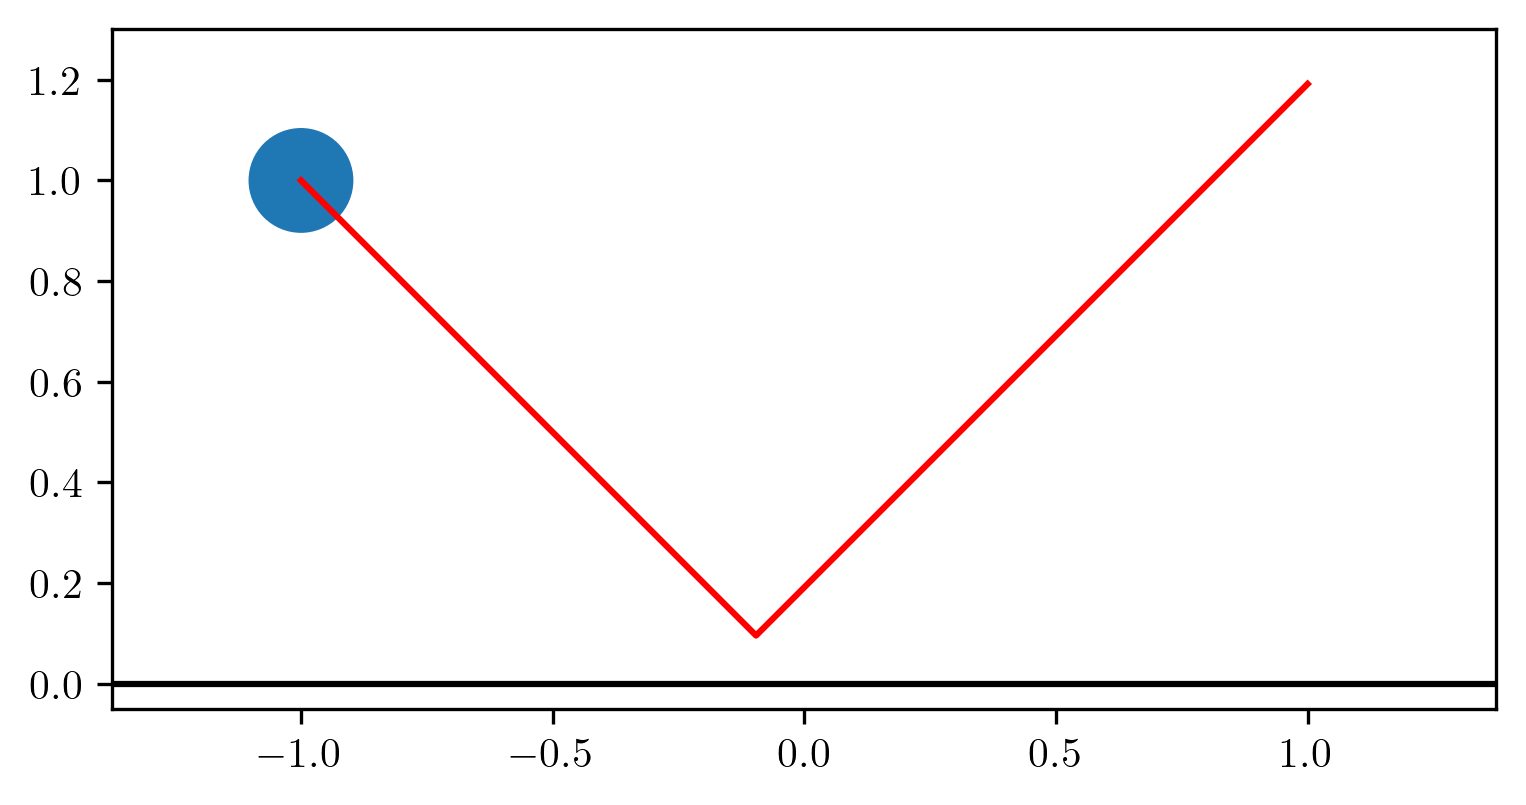

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=300)
ax.set_aspect('equal')
ax.set(ylim=(-0.05, 1.3))
ax.plot(traj[:, 0].detach().cpu().numpy(), traj[:, 1].detach().cpu().numpy(), color='red')
ax.axline(xy1=(-1.25, 0), xy2=(1.25, 0), color="k")
# ax.axhline(y=0, xmin=-2, xmax=1.75)
# ax.axvline(x=1.75, ymin=0, ymax=1.75, color="k")
circle_ball = plt.Circle((-1., 1.0), 0.1, color='tab:blue', fill=True)
ax.add_patch(circle_ball)
# fig.savefig(os.path.join(FIG_DIR, "bounce_once_traj.png"), bbox_inches="tight")